# Mixology
v0.3.7

## Environment Setup

In [1]:
!pip install typedb-client
!pip install gensim==4.0.1

!rm -rf mixology
!git clone https://github.com/yintrigue/mixology
%cd mixology

from google.colab import output
output.clear()

In [7]:
import os
import pickle
import copy
import networkx as nx
import networkx.algorithms.isomorphism as iso
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import azlib.utils as azutils

from collections import Counter
from collections import defaultdict
from tqdm import tqdm
from typedb.client import *
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

METAPATH_PKL_FILES = ['graphs_fcncf.pkl', 'graphs_ncfcn.pkl', 'graphs_nncfcnn.pkl']
if 'google.colab' in str(get_ipython()):
  PWD = './'
else:
  PWD = os.path.dirname(os.path.realpath("__file__"))

## Data Loading

In [8]:
# load id_to_name mapping
with open(f'{PWD}/data/map_id_to_name.pkl', "rb") as f:
    print('Loading map_id_to_name...')
    map_id_to_name = pickle.load(f)

# load map_n_id_to_name mapping
with open(f'{PWD}/data/map_n_id_to_name.pkl', "rb") as f:
    print('Loading map_n_id_to_name...')
    map_n_id_to_name = pickle.load(f)

# load map_c_id_to_name mapping
with open(f'{PWD}/data/map_c_id_to_name.pkl', "rb") as f:
    print('Loading map_c_id_to_name...')
    map_c_id_to_name = pickle.load(f)

# load name_to_id mapping
with open(f'{PWD}/data/map_name_to_id.pkl', "rb") as f:
    print('Loading map_name_to_id...')
    map_name_to_id = pickle.load(f)

print('Completed!')

Loading map_id_to_name...
Loading map_n_id_to_name...
Loading map_c_id_to_name...
Loading map_name_to_id...
Completed!


## Skipgram Training

In [11]:
model = Word2Vec.load(f'{PWD}/models/word2vec.wordvectors')

# retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

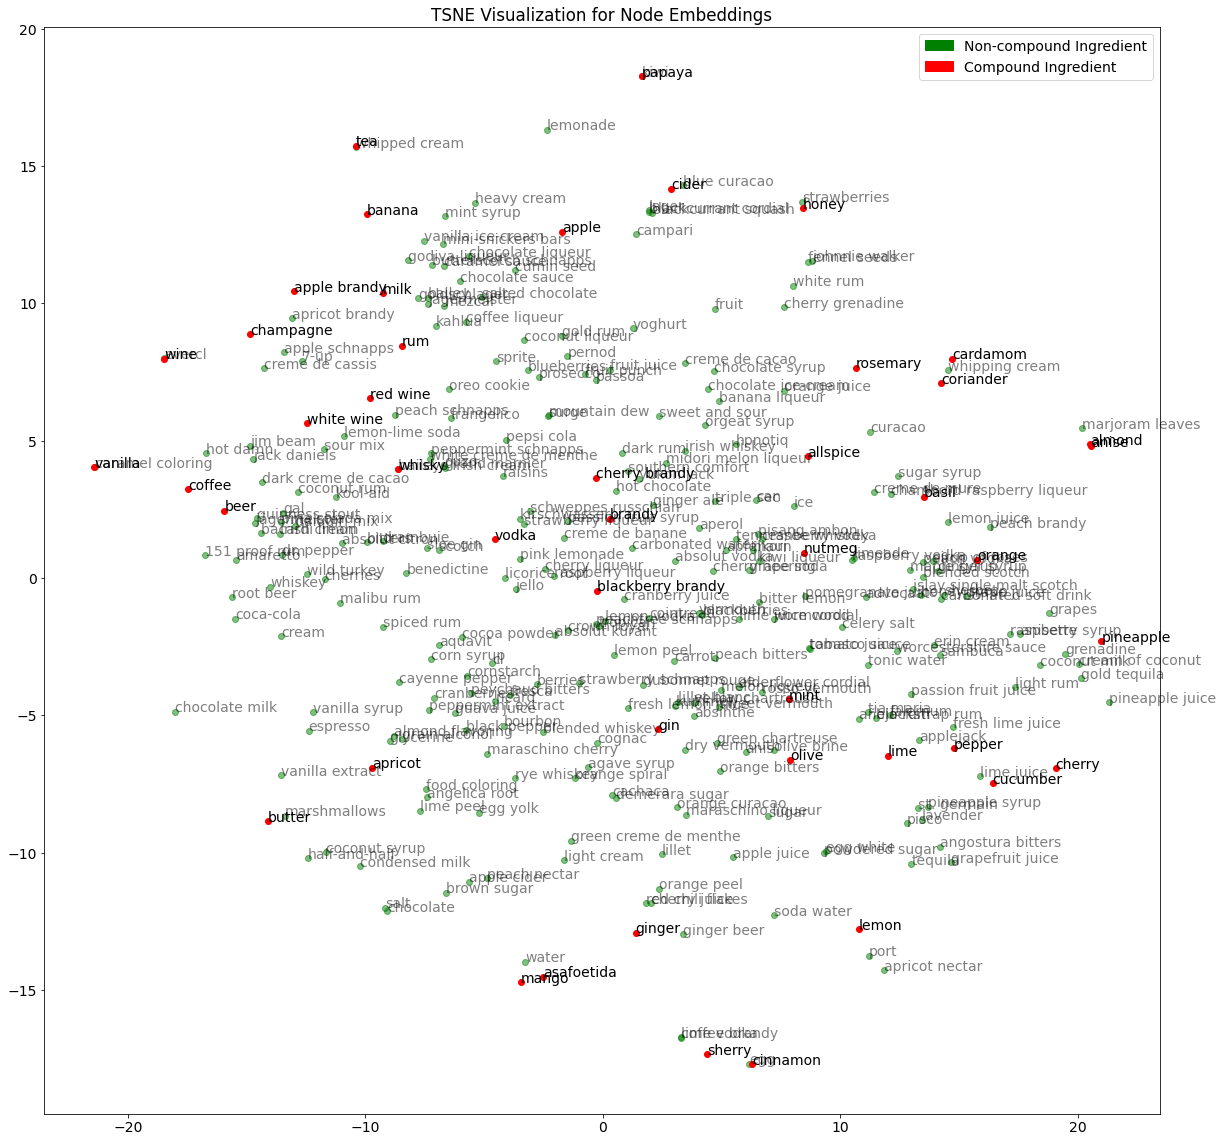

In [12]:
model_ingredient_names, model_ingredient_vectors, node_count_compound_ingred = \
    azutils.get_model_ingredient_vectors_names(
        model = model, 
        map_c_id_to_name=map_c_id_to_name, 
        map_n_id_to_name=map_n_id_to_name, 
        verbose=False
    )

# dim reduction for plotting
transform = TSNE  # PCA or TSNE
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(model_ingredient_vectors)
    
def plot_ingredients(*args, **kwargs) -> None:
    """Proxy function to azutils.plot_ingredients. This is just a quick "hack" so 
    we don't have to repeated enter the same arguments. 
    """
    azutils.plot_ingredients(
        transform_name               = transform.__name__,
        node_embeddings_2d           = node_embeddings_2d,
        node_names                   = np.array(model_ingredient_names),
        indice_non_compound_ingred   = (node_count_compound_ingred, None),
        indice_compound_ingred       = (0, node_count_compound_ingred),
        **kwargs
    )

plot_ingredients(fig_size=(20, 20))

## Ingredient Paring Analysis

### Pairing by Cosine Distance

Ingredient(s): ['bourbon', 'sugar', 'water']
            Ingredient  Absolute Cosine Distance  Cosine Distance
0               ricard                  0.658960         0.658960
1     peychaud bitters                  0.650772         0.650772
2        grain alcohol                  0.641509         0.641509
3   peppermint extract                  0.615917         0.615917
4                 salt                  0.612334         0.612334
5               fresca                  0.611851         0.611851
6       cherry heering                  0.611210         0.611210
7                   cl                  0.599031         0.599031
8  strawberry schnapps                  0.596810         0.596810
9                jello                  0.589758         0.589758


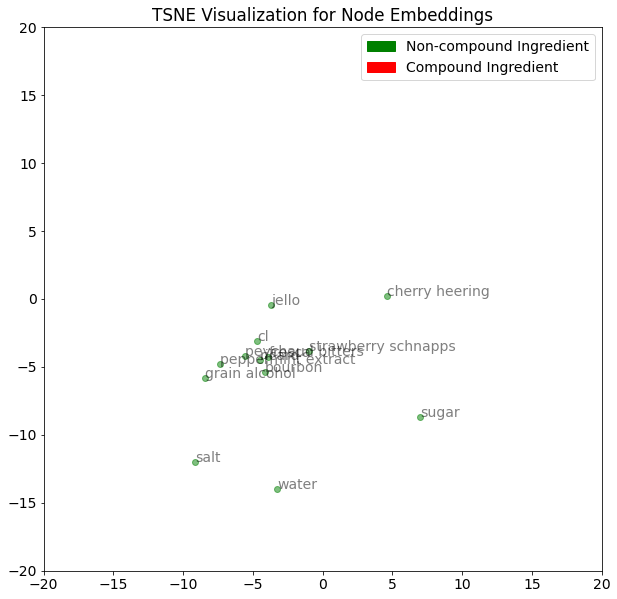

In [13]:
INGREDIENTS = ['bourbon', 'sugar', 'water']
pairings, scores = azutils.find_pairings_by_cos(
                                        INGREDIENTS, 
                                        model, 
                                        model_ingredient_names, 
                                        top_n_pairings=10)
cos_scores_abs = [score['score_abs'] for score in scores]
cos_scores_reg = [score['score'] for score in scores]

# print report
results_df = pd.DataFrame({
                'Ingredient': pairings,
                'Absolute Cosine Distance': cos_scores_abs,
                'Cosine Distance': cos_scores_reg})
print(f'Ingredient(s): {INGREDIENTS}')
print(results_df)

# plot ingredients
ingredient_names = INGREDIENTS
ingredient_names.extend(pairings)
if transform.__name__ == 'TSNE':
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-20, 20))
else:
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-2, 2))

### Pairing by NPMI

In [14]:
INGREDIENT = "egg"

# load the npmi scores for all ingredient-ingredient pairs from the migrators
npmi_pair_scores, _ = azutils.get_npmi_pairs()
top_n_pairings, paired_ingredients = azutils.recipe_based_pairings(INGREDIENT, 10, npmi_pair_scores)

# print top_n results
results_df = pd.DataFrame({'Ingredient': top_n_pairings.keys(), 'NPMI Score': top_n_pairings.values()})
print(f'Ingredient: {INGREDIENT}')
print(results_df)

Ingredient: egg
        Ingredient  NPMI Score
0           nutmeg    0.660120
1           sherry    0.573506
2   condensed milk    0.482453
3      light cream    0.473850
4  vanilla extract    0.451367
5   powdered sugar    0.432779
6             milk    0.407656
7             port    0.402238
8        chocolate    0.373608
9        coca-cola    0.278426


### Pairing Cosine Distance vs. NPMI

Ingredient: coffee
  Pairing Ingredient  Absolute Cosine Distance  Cosine Distance  NPMI Score
0    pina colada mix                  0.374464         0.374464    0.000000
1   caramel coloring                  0.373534         0.373534    0.482453
2       daiquiri mix                  0.362219         0.362219    0.000000
3             evercl                  0.352451         0.352451    0.264762
4        irish cream                  0.348059         0.348059    0.000000
5           hot damn                  0.340100         0.340100    0.000000
6                tea                  0.328860         0.328860    0.000000
7     peach schnapps                  0.327244         0.327244    0.000000
8               wine                  0.326539         0.326539    0.000000
9       jack daniels                  0.326170         0.326170    0.264762


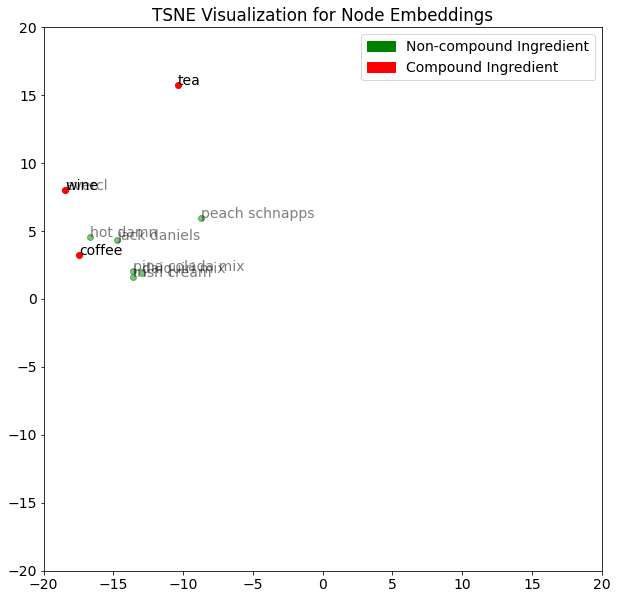

In [15]:
INGREDIENT = "coffee"

# load cosine
paired_ingredients, cos_scores = azutils.find_pairings_by_cos(
                                        [INGREDIENT], 
                                        model, 
                                        model_ingredient_names, 
                                        top_n_pairings=10)
cos_scores_abs = [score['score_abs'] for score in cos_scores]
cos_scores_reg = [score['score'] for score in cos_scores]

# load npmi
paired_ingredients_npmi_dict = azutils.load_npmi_scores(INGREDIENT, paired_ingredients)

# print report
results_df = pd.DataFrame({
                'Pairing Ingredient': paired_ingredients, 
                'Absolute Cosine Distance': cos_scores_abs,
                'Cosine Distance': cos_scores_reg, 
                'NPMI Score': paired_ingredients_npmi_dict.values()
            })
print(f'Ingredient: {INGREDIENT}')
print(results_df)

# plot ingredients
ingredient_names = [INGREDIENT]
ingredient_names.extend(paired_ingredients)
if transform.__name__ == 'TSNE':
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-20, 20))
else:
    plot_ingredients(
        filter_names = ingredient_names, 
        fig_size=(10, 10),
        axis_lim=(-2, 2))